**PyImageJ Tutorial**

This notebook covers how to use ImageJ as a library from Python. A major advantage of this approach is the ability to combine ImageJ with other tools available from the Python software ecosystem, including NumPy, SciPy, scikit-image, CellProfiler, OpenCV, ITK and more.

This notebook assumes familiarity with the ImageJ API. Detailed tutorials in that regard can be found in the other notebooks.

# 8 Discover ImageJ commands with the Recorder

The original ImageJ contains many useful commands that can be hard to use in PyImageJ without some prior knowledge on the their parameters. This notebook demonstrates how to use ImageJ's `Recorder` feature to record ImageJ commands in a supported language (`IJ Macro`, `BeanScript`, `Java` and `JavaScript`). 

## 8.1 Example 1: Apply "Find Maxima..." command to an image

In this example we will use "Find Maxima" on a test image. Once the image is loaded, open the `Recorder` (see image below) and begin running commands to capture the code lines.

![Open macro recorder](doc-images/imagej_ui_macro_recorder.png)

Now that the `Recorder` window is open and listening for commands, set the recorder language to either `Java` or `JavaScript` before running the "Find Maxima..." command. Next run the "Find Maxima..." command (**Process** > **Find Maxima...**) to capture the code lines.

![Macro recorder](doc-images/macro_recorder_find_maxima.png)

Running "Find Maxima..." (set to `prominence=1000` and `Point Selection`) on `test_still.tif` results in 21 detections which are then overlayed over the input image.:

![Result](doc-images/test_still_find_maxima.png)

Now that we have the `Java` code for the "Find Maxima..." command we can replicate this workflow in PyImageJ. The "Find Maxima..." command will overlay detections ontop of a displayed input image, therefore we will need to initialize ImageJ in `interactive` mode. Please note that MacOS users will have to change the mode to `gui` due to architecture limitations. For more information please visit the [initialization](Initialization.md) documentation.

In [1]:
import imagej

# initialize ImageJ2
ij = imagej.init(mode='headless')
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.5.0/1.53r


Because the "Find Maxima..." and other original ImageJ commands work with the `ImagePlus` object type (instead of the newer ImageJ2/ImgLib2 `Dataset` and `ImgPlus` object types) we need to first convert the `Dataset` returned from `ij.io().open()` to an `ImagePlus`.

**Note:** There is a currently a bug

In [2]:
# HACK: # HACK: Work around ImagePlus#show() failure if no ImagePlus objects are already registered.
if ij.WindowManager.getIDList() is None:
    ij.py.run_macro('newImage("dummy", "8-bit", 1, 1, 1);')

Operating in headless mode - the original ImageJ will have limited functionality.
Operating in headless mode - the WindowManager class will not be fully functional.


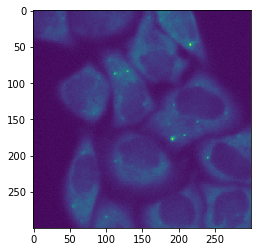

In [3]:
# open test image and convert from Dataset to ImagePlus
dataset = ij.io().open('sample-data/test_still.tif')
imp = ij.py.to_imageplus(dataset)

# show the image
ij.py.show(imp)

Next, show the image with ImageJ and run `Find Maxima...` using the same `Java` syntax generated from the recorder.

In [4]:
# show image and then find maxima
imp.getProcessor().resetMinAndMax()
ij.ui().show(imp)
ij.IJ.run(imp, "Find Maxima...", "prominence=1000 output=[Point Selection]")

[java.lang.Enum.toString] [INFO] null = img["test_still.tif" (-3), 16-bit, 300x300x1x1x1]
Operating in headless mode - the IJ class will not be fully functional.


[INFO] null = img["test_still.tif" (-3), 16-bit, 300x300x1x1x1]


## 8.2 Example 2: Extract a slice and run "Analyze Particles..."

Let's try a more complicated example next. This Java code was generated with the ImageJ Recorder while analyzing some data.

```java
imp = IJ.openImage("sample-data/test_timeseries.tif");
imp2 = new Duplicator().run(imp, 3, 3, 1, 1, 14, 14);
IJ.run(imp, "Enhance Contrast", "saturated=0.35");
IJ.setAutoThreshold(imp, "Moments dark");
IJ.run(imp, "Analyze Particles...", "  show=Overlay display clear");
```

The Java code takes the `test_timeseries.tif` sample data (4D: [X, Y, Channel, Time]) and performs the following operations:

1. Open the test data.
2. Duplicate channel 3, frame 14 (extracts a single still from the timeseries).
3. Enhance the contrast of the image.
4. Threshold with "Moments dark".
5. Analyze particles and display results via overlay.

**Results:**

![Analyze Particles](doc-images/test_still_analyze_particles.png)

Note that in this example we will use the orginal ImageJ's image opener (`IJ.openImage()`) instead of ImageJ2's (`ij.io().open()`). The original ImageJ's opener is more limited than ImageJ2's however it will return an `ImagePlus` image object instead of a `Dataset`, thus no conversion step is needed like in the previous example.

Just like in the _Example 1_ the `Java` code generated from the Recorder can be typically used with little to no modification for language syntax (take note of the different syntax needed to use the `Duplicator`):

In [5]:
# get ImageJ's duplicator
Duplicator = sj.jimport('ij.plugin.Duplicator')

# run ImageJ commands
imp_timeseries = IJ.openImage("sample-data/test_timeseries.tif")
imp_extract = Duplicator().run(imp_timeseries, 3, 3, 1, 1, 14, 14) # visit the Javadoc for more info https://imagej.nih.gov/ij/developer/api/ij/ij/plugin/Duplicator.html
ij.IJ.run(imp_extract, "Enhance Contrast", "saturated=0.35")
ij.ui().show(imp_extract)
ij.IJ.setAutoThreshold(imp_extract, "Moments dark")
ij.IJ.run(imp_extract, "Analyze Particles...", " show=Overlay display clear")

[INFO] null = img["DUP_test_timeseries.tif" (-6), 16-bit, 250x250x1x1x1]
 	Area	Mean	Min	Max	X	Y	IntDen	RawIntDen
1	0.211	1293	1141	1445	48.588	13.975	273.146	2586
2	0.739	1216.143	1085	1473	28.716	14.927	899.186	8513
3	0.106	1333.000	1333	1333	25.838	16.738	140.798	1333
4	0.528	1193.400	1099	1295	31.753	17.518	630.264	5967
5	0.317	1241.667	1087	1384	43.604	17.604	393.453	3725
6	180.091	1513.540	1083	4462	52.667	27.076	272574.304	2580585
7	0.106	1104.000	1104	1104	58.988	17.388	116.610	1104
8	3.803	1478.194	1085	2510	29.728	19.121	5620.835	53215
9	0.211	1268.000	1161	1375	50.213	17.875	267.865	2536
10	0.211	1171.000	1108	1234	25.838	18.200	247.374	2342
11	0.106	1257.000	1257	1257	32.663	18.038	132.771	1257
12	0.423	1371.250	1186	1686	32.825	19.175	579.353	5485
13	0.317	1140.667	1109	1157	43.929	19.446	361.449	3422
14	0.423	1187.500	1097	1241	54.925	19.825	501.719	4750
15	0.528	1182.800	1132	1312	55.998	20.053	624.666	5914
16	0.423	1302.500	1117	1634	21.938	20.556	550.306	5210
17	0.739	

[java.lang.Enum.toString] [INFO] null = img["DUP_test_timeseries.tif" (-6), 16-bit, 250x250x1x1x1]
[java.lang.Enum.toString]  	Area	Mean	Min	Max	X	Y	IntDen	RawIntDen[java.lang.Enum.toString] 
[java.lang.Enum.toString] 1	0.211	1293	1141	1445	48.588	13.975	273.146	2586[java.lang.Enum.toString] 
[java.lang.Enum.toString] 2	0.739	1216.143	1085	1473	28.716	14.927	899.186	8513[java.lang.Enum.toString] 
[java.lang.Enum.toString] 3	0.106	1333.000	1333	1333	25.838	16.738	140.798	1333[java.lang.Enum.toString] 
[java.lang.Enum.toString] 4	0.528	1193.400	1099	1295	31.753	17.518	630.264	5967[java.lang.Enum.toString] 
[java.lang.Enum.toString] 5	0.317	1241.667	1087	1384	43.604	17.604	393.453	3725[java.lang.Enum.toString] 
[java.lang.Enum.toString] 6	180.091	1513.540	1083	4462	52.667	27.076	272574.304	2580585[java.lang.Enum.toString] 
[java.lang.Enum.toString] 7	0.106	1104.000	1104	1104	58.988	17.388	116.610	1104[java.lang.Enum.toString] 
[java.lang.Enum.toString] 8	3.803	1478.194	1085	2510	29.728	19

### ImageJ macro language

It is possible to record workflows in the original ImageJ macro language and run those macros in PyImageJ with `ij.py.run_macro()` (see the[7-Running-Macros-Scripts-and-Plugins](7-Running-Macros-Scripts-and-Plugins.ipynb) notebook for more information). While this is functional, we do not recommend using the macro language as it is more fragile and less powerful due to the orignal ImageJ internal operations. For example, macros are single threaded only and do not take advantage of multi-threaded processing. For more information on ImageJ macro limitations please visit the [macro](https://imagej.net/scripting/macro#overcoming-limitations) wiki page.